In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from scipy import signal
from numpy import linalg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [4]:
import mne

In [5]:
from stats import logvar
import stats

# Loading, filtering and extracting data

In [6]:
raw = mne.io.read_raw_edf('data/Dual_Aural.edf', preload=True)

Extracting EDF parameters from /home/delta_c/EnW/Biotech_Researches/EEG_Event_Classification/data/Dual_Aural.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 359499  =      0.000 ...   718.998 secs...


/tmp/ipykernel_16225/3131080669.py:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'SAO2'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf('data/Dual_Aural.edf', preload=True)


In [7]:
raw.drop_channels(raw.ch_names[-5:])

Measurement date,"September 09, 2024 11:41:48 GMT"
Experimenter,Unknown
Participant,5d106bf1-e0b7-4ff8-a364-276fbd64079f
Digitized points,Not available
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


In [8]:
mapping = dict(zip(raw.ch_names, ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']))

In [9]:
raw.rename_channels(mapping)

Measurement date,"September 09, 2024 11:41:48 GMT"
Experimenter,Unknown
Participant,5d106bf1-e0b7-4ff8-a364-276fbd64079f
Digitized points,Not available
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.00 Hz
Lowpass,250.00 Hz


In [10]:
sample_rate = raw.info['sfreq']

**Converting into pandas dataframe (optional)**

In [11]:
data = raw['data'][0].T
df = raw.to_data_frame()
df = df.drop(['time'], axis=1)

final_columns = list(df.columns)
final_columns.append('mark')
final_columns

df.describe()

,FP1,FP2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T3,T4,T5,T6,Fz,Cz,Pz
count,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000,359500.000000
mean,0.187453,0.057374,0.229305,0.064663,0.184159,0.051289,0.195124,0.057817,0.123022,0.050712,0.194127,0.054478,0.195113,0.039941,0.232864,0.048647,-0.047536,-0.042587,-0.073291
std,214.701533,90.628992,213.845982,77.348176,210.617800,75.700513,210.729811,75.046508,209.203399,74.556884,215.776242,81.823471,215.572394,85.051901,213.297812,75.486350,115.621356,124.114375,102.593971
min,-3976.961861,-3139.115887,-3821.552994,-3150.719308,-3747.302488,-3142.457913,-3915.868622,-3127.972760,-3654.060000,-3138.822738,-3921.950000,-3150.025882,-3945.377697,-3172.661118,-3659.306350,-3091.622748,-6484.540000,-6464.997519,-6451.840000
25%,-16.302158,-18.395770,-12.429483,-13.584834,-12.124318,-13.172724,-12.444381,-13.946328,-10.258525,-11.382950,-13.655690,-15.170284,-11.614366,-12.215077,-10.953978,-12.770812,-9.196294,-11.247351,-8.868986
50%,-2.115662,-2.950522,-0.567981,-1.227136,-0.002140,-0.659338,0.101780,-0.463634,0.250469,-0.381905,-0.501765,-1.632871,0.189284,-0.737982,0.242878,-0.394971,-0.717139,0.013186,-0.114335
75%,11.019984,12.650738,11.557109,11.912694,12.120037,12.166884,12.647940,13.177680,10.503147,10.933455,12.126004,13.006424,11.730632,11.210774,11.179342,12.141595,8.193159,11.566204,8.942202
max,13238.351861,7083.141950,13314.626411,7098.817573,13153.850000,7106.944331,13213.300000,7266.232520,12735.869765,7158.783527,13318.636921,7163.908765,13243.885393,7129.367898,13276.850000,7439.092374,2932.495570,3118.304519,3440.011058


**PSD and filtering**

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_16225/4108630121.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.compute_psd().plot()
/tmp/ipykernel_16225/4108630121.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
/home/delta_c/.local/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


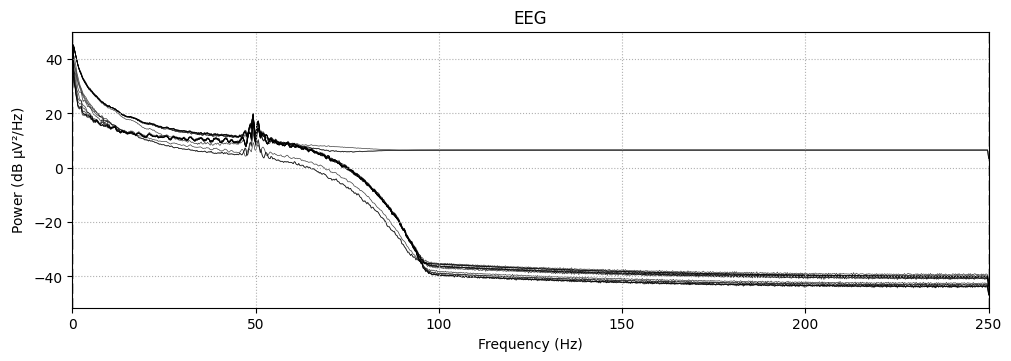

In [12]:
raw.compute_psd().plot()

# Events searching

In [13]:
raw_events = mne.events_from_annotations(raw)

events_from_raw = []
for event in raw_events[0][1:-1]:
    events_from_raw.append([event[0], event[-1]])

events_from_raw

Used Annotations descriptions: [np.str_('pointPolySomnographyPatientLieDownSpine'), np.str_('Закрывание глаз (testUser)'), np.str_('Открывание глаз (testUser)'), np.str_('Фоновая запись (testUser)')]


[[np.int64(7548), np.int64(1)],
 [np.int64(17072), np.int64(3)],
 [np.int64(63872), np.int64(2)],
 [np.int64(154144), np.int64(3)],
 [np.int64(196000), np.int64(2)],
 [np.int64(323936), np.int64(3)]]

In [14]:
events = []

mark_l = list(range(17072, 17072 + int(60.1 * 500), 500))
mark_r = list(range(154144, 154144 + int(60.1 * 500), 500))
for stamp in mark_l:
    events.append([stamp, 0])
for stamp in mark_r:
    events.append([stamp, 1])

events

[[17072, 0],
 [17572, 0],
 [18072, 0],
 [18572, 0],
 [19072, 0],
 [19572, 0],
 [20072, 0],
 [20572, 0],
 [21072, 0],
 [21572, 0],
 [22072, 0],
 [22572, 0],
 [23072, 0],
 [23572, 0],
 [24072, 0],
 [24572, 0],
 [25072, 0],
 [25572, 0],
 [26072, 0],
 [26572, 0],
 [27072, 0],
 [27572, 0],
 [28072, 0],
 [28572, 0],
 [29072, 0],
 [29572, 0],
 [30072, 0],
 [30572, 0],
 [31072, 0],
 [31572, 0],
 [32072, 0],
 [32572, 0],
 [33072, 0],
 [33572, 0],
 [34072, 0],
 [34572, 0],
 [35072, 0],
 [35572, 0],
 [36072, 0],
 [36572, 0],
 [37072, 0],
 [37572, 0],
 [38072, 0],
 [38572, 0],
 [39072, 0],
 [39572, 0],
 [40072, 0],
 [40572, 0],
 [41072, 0],
 [41572, 0],
 [42072, 0],
 [42572, 0],
 [43072, 0],
 [43572, 0],
 [44072, 0],
 [44572, 0],
 [45072, 0],
 [45572, 0],
 [46072, 0],
 [46572, 0],
 [47072, 0],
 [154144, 1],
 [154644, 1],
 [155144, 1],
 [155644, 1],
 [156144, 1],
 [156644, 1],
 [157144, 1],
 [157644, 1],
 [158144, 1],
 [158644, 1],
 [159144, 1],
 [159644, 1],
 [160144, 1],
 [160644, 1],
 [161144, 1

# Segmentation

In [15]:
sample_rate = raw.info['sfreq']
win = np.arange(int(0.02 * sample_rate), int(0.22 * sample_rate))
len(win)

100

In [16]:
trials = []

for event in events:
    for i in win:
        row = []
        for j in range(20):
            if j < 19:
                row.append(data[event[0] + i][j] * 1e6)
            else:
                row.append(event[1])
        trials.append(row)

trials = np.array(trials)

trials_df = pd.DataFrame(trials, columns=final_columns)

In [17]:
dataset_l:np.ndarray = trials[:6100]
dataset_l:np.ndarray = np.delete(dataset_l, np.s_[-1], axis=1)

dataset_r:np.ndarray = trials[6100:]
dataset_r:np.ndarray = np.delete(dataset_r, np.s_[-1], axis=1)

windows_l:np.ndarray = dataset_l.T.reshape(19, 100, 61)
y_l:np.ndarray = np.zeros((61, 1))

windows_r:np.ndarray = dataset_r.T.reshape(19, 100, 61)
y_r:np.ndarray = np.ones((61, 1))

# Logvar fuction and computing variances

In [18]:
variances = []

trials_df_l = trials_df[trials_df['mark'] == 0]
trials_df_r = trials_df[trials_df['mark'] == 1]

l_var = []
for col in final_columns[:-1]:
    l_var.append(logvar(trials_df_l[col]))
l_var.append(0.0)

variances.append(l_var)

r_var = []
for col in final_columns[:-1]:
    r_var.append(logvar(trials_df_r[col]))
r_var.append(1.0)

variances.append(r_var)

In [19]:
variances = pd.DataFrame(variances, columns=final_columns)

variances.iloc[0] - variances.iloc[1]

FP1     0.021101
FP2    -0.174098
F3      0.208765
F4     -0.229962
C3      0.116953
C4     -0.217047
P3      0.034289
P4     -0.198959
O1      0.133610
O2     -0.150041
F7      0.312310
F8     -0.022295
T3      0.023038
T4     -0.032449
T5     -0.049240
T6     -0.137407
Fz     -0.084883
Cz     -0.619336
Pz     -0.262278
mark   -1.000000
dtype: float64

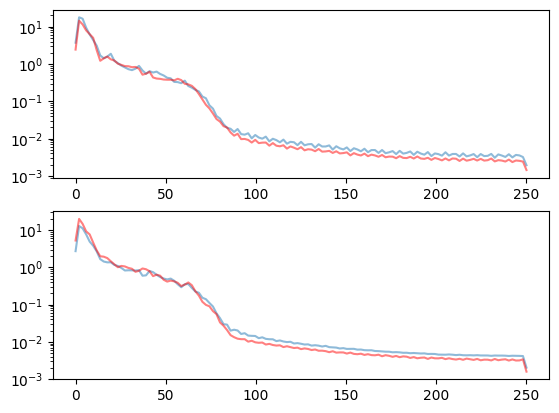

In [28]:
f1, Pxx_den1 = signal.welch(windows_l[2, :, :].reshape(6100,), sample_rate, nperseg=256)
f2, Pxx_den2 = signal.welch(windows_r[2, :, :].reshape(6100,), sample_rate, nperseg=256)

f1_2, Pxx_den1_2 = signal.welch(windows_l[3, :, :].reshape(6100,), sample_rate, nperseg=256)
f2_2, Pxx_den2_2 = signal.welch(windows_r[3, :, :].reshape(6100,), sample_rate, nperseg=256)

fig, ax = plt.subplots(2)

ax[0].semilogy(f1, Pxx_den1, alpha=0.5)
ax[0].semilogy(f2, Pxx_den2, c='red', alpha=0.5)

"""ax[0].xlabel('frequency [Hz]')
ax[0].ylabel('PSD $[V^2/Hz]$')"""

ax[1].semilogy(f1_2, Pxx_den1_2, alpha=0.5)
ax[1].semilogy(f2_2, Pxx_den2_2, c='red', alpha=0.5)

"""ax[1].xlabel('frequency [Hz]')
ax[1].ylabel('PSD $[V^2/Hz]$')"""

plt.show()

# CSP and postprocessing

In [21]:
trials_filt = {'left': stats.bandpass(windows_l, 2, 15, sample_rate),
               'right': stats.bandpass(windows_r, 2, 15, sample_rate)}

In [22]:
psd_r, freqs = stats.psd(trials_filt['left'], sample_rate)
psd_f, freqs = stats.psd(trials_filt['right'], sample_rate)
trials_PSD = {'left': psd_r, 'right': psd_f}

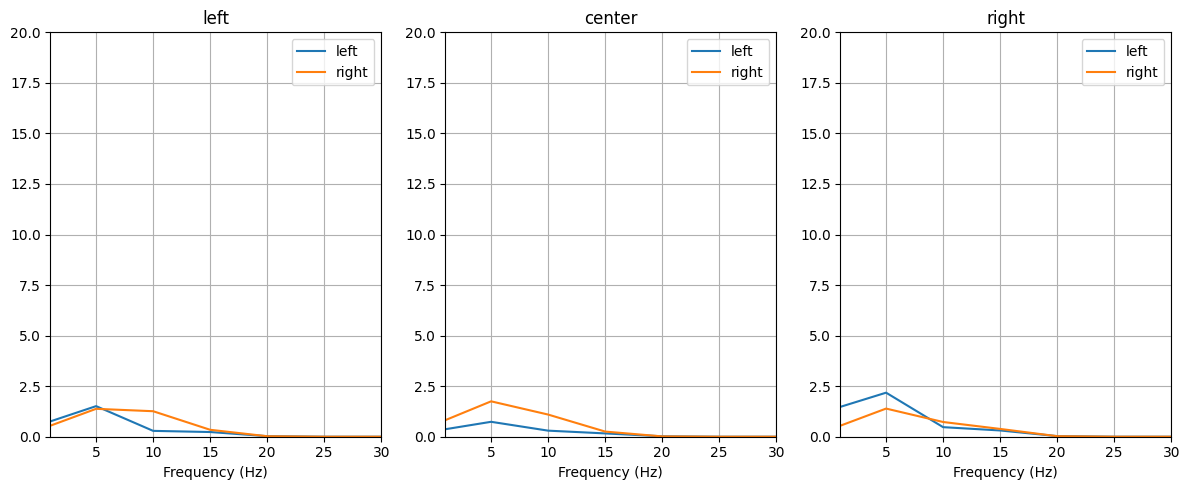

In [23]:
stats.plot_psd(
    trials_PSD,
    trials_filt,
    freqs,
    [2, 17, 3],
    chan_lab=['left', 'center', 'right'],
    maxy=20
)

In [24]:
W = stats.csp(trials_filt['left'], trials_filt['right'])
trials_csp = {'left': stats.apply_mix(W, trials_filt['left']),
              'right': stats.apply_mix(W, trials_filt['right'])}

In [25]:
trials_logvar = {'left': logvar(trials_csp['left'], axis=1),
                 'right': logvar(trials_csp['right'], axis=1)}

In [26]:
stats.plot_logvar(trials_logvar, trials_filt)

# LDA and metrics